<a name='introduction'></a>
# Проект "Выбор локации для скважины"

Нужно решить, где бурить новую скважину для нефтяной компании.
Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

План проекта:
1. [Импорт библиотек и подготовка файлов](#import)
2. [Обучение и проверка модели](#model_training)
3. [Подготовка к расчету прибыли](#profit_calculation)
4. [Расчет прибыли и убытков](#profit_appraisal)
5. [Общий Вывод](#conclusion)

<a name='import'></a>
## 1. Импорт библиотек и подготовка файлов

In [2]:
# Импорт библиотек и функций
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Константы
BUDGET = 10**10
PROFIT_PER_UNIT = 450000
OILWELL_500 = 500
OILWELL_200 = 200

In [3]:
geo1 = pd.read_csv("geo_data_0.csv")
geo2 = pd.read_csv("geo_data_1.csv")
geo3 = pd.read_csv("geo_data_2.csv")

In [4]:
print(geo1.info())
print(geo2.info())
print(geo3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Далее удалим столбец 'id' во всех трех датасетах, поскольку каждое значение уникально, и для модели в нем нет необходимости.

In [5]:
geo1 = geo1.drop('id', axis=1)
geo2 = geo2.drop('id', axis=1)
geo3 = geo3.drop('id', axis=1)

In [10]:
display("Регион 1:", geo1.describe())
display("Регион 2:", geo2.describe())
display("Регион 3:", geo3.describe())

'Регион 1:'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Регион 2:'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Регион 3:'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [11]:
# Корреляции между параметрами по каждому региону
display("Регион 1:", geo1.corr())
display("Регион 2:", geo2.corr())
display("Регион 3:", geo3.corr())

'Регион 1:'

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


'Регион 2:'

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


'Регион 3:'

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Промежуточный вывод:**

Можно заметить, что знаения признаков могут в зависимости от региона довольно сильно разниться. Так, например, максимальное значение признака "f2" по Регионам №1 и №3 почти совпадают (~ 16), а в Регионе №2 - ниже более, чем в три раза (~5). Тем не менее, поскольку данные синтетические, сложно однозначно сказать, или подобные колебания значения являются нормой.

Рассмотрев корреляцию между признаками - f0, f1, f2 - и объемом запасов, можно заметить, что признаки "f0" и "f1" не сильно влияют на объем запасов, в то время как "f2" так или иначе демонстрирует некое взаимосвязь с объемом запасов. Примечательно, что в Регионе № 2 зависимость почти полностью прямая. Ввиду этого можно сказать, что наибольшую роль при определении объемом запасов влияет именно признак "f2", однако учитывать другие признаки также необходимо, поскольку они могут быть в той или иной степени связаны между собой.

<a name='model_training'></a>
## 2. Обучение и проверка модели
[Вернуться во Введение](#introduction)

Разделим показатели датасетов по каждому из регионов на признаки и на целевой признак. В соответствии с номером регионы, переменные признаки будут иметь соответствующую цифру (1-3).

In [8]:
def divide_data(geo):
    features = geo.drop('product', axis=1)
    target = geo['product']
    return features, target

In [9]:
X1, y1 = divide_data(geo1)

X2, y2 = divide_data(geo2)

X3, y3 = divide_data(geo3)

Разобьем признаки и целевой признак на обучающую, валидационную выборки.

In [10]:
def create_samples(features, target):
    return train_test_split(
        features,
        target,
        test_size=0.25, 
        random_state=42
    )

In [11]:
# Регион №1
X1_train, X1_valid, y1_train, y1_valid = create_samples(X1, y1)

# Регион №2
X2_train, X2_valid, y2_train, y2_valid = create_samples(X2, y2)

# Регион №3
X3_train, X3_valid, y3_train, y3_valid = create_samples(X3, y3)

Создадим и обучим модель Линейной регрессии. Далее рассмотрим среднее предсказанное количество запасов нефти и среднеквадратичную ошибку (RMSE).

In [12]:
def model_training(geo_num, features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    target_pred = model.predict(features_valid)
    rmse = round(mean_squared_error(target_valid, target_pred) ** 0.5, 3)
    product_mean = round(target_pred.mean())
    
    print("Средний запас предсказанного сырья (в тыс.):", product_mean)
    print(f"RMSE Региона №{geo_num} (в тыс.): {rmse}\n")
    
    return target_pred

In [13]:
y1_pred = model_training(1, X1_train, X1_valid, y1_train, y1_valid)
y2_pred = model_training(2, X2_train, X2_valid, y2_train, y2_valid)
y3_pred = model_training(3, X3_train, X3_valid, y3_train, y3_valid)

Средний запас предсказанного сырья (в тыс.): 92
RMSE Региона №1 (в тыс.): 37.757

Средний запас предсказанного сырья (в тыс.): 69
RMSE Региона №2 (в тыс.): 0.89

Средний запас предсказанного сырья (в тыс.): 95
RMSE Региона №3 (в тыс.): 40.146



**Промежуточный вывод:**

Примечательно, что в Регионах №1 и №3 наблюдаются более высокие значения среднего запаса предсказанного сырья - 95 и 93 тыс. баррелей соответственно, в то время как в Регионе №2 - лишь 69 тыс. баррелей. Однако, в то же самое время для Регионов №1 и №3 характерны более высокие значения среднеквадратичной ошибки - 37 и 40 соответственно, а для Региона №2 - только 0,89. 

<a name='profit_calculation'></a>
## 3. Подготовка к расчёту прибыли
[Вернуться во Введение](#introduction)

In [14]:
min_avg_top_200 = round(BUDGET / (PROFIT_PER_UNIT * OILWELL_200), 2)

print("Минимальный запас сырья по топ-200 скважин для безубыточности должен быть:", min_avg_top_200)

Минимальный запас сырья по топ-200 скважин для безубыточности должен быть: 111.11


Поскольку "ГлавРосГосНефть" планирует разработать 200 лучших скважин для разработки, посмотрим средние значения объема запасов 200 скважин с наибольшим показателем "product" в каждом регионе.

In [15]:
def random_top_200(geo):
    state = RandomState(12345)
    random_sample = geo.sample(n=500, random_state=state)
    random_top_200 = random_sample.sort_values(by='product', ascending=False)[:200]
    return round(random_top_200['product'].mean(), 2)

print("Средний объем запасов 200 лучших скважин по случайной выборке из 500 скажин по регионам (в тыс.):")
print("    Регион 1:", random_top_200(geo1))
print("    Регион 2:", random_top_200(geo2))
print("    Регион 3:", random_top_200(geo3))

Средний объем запасов 200 лучших скважин по случайной выборке из 500 скажин по регионам (в тыс.):
    Регион 1: 133.76
    Регион 2: 114.63
    Регион 3: 138.12


**Промежуточный вывод:**

На основе полученных результатов можно увидеть, что в Регионах №1 и №3 средние показатели объема запасов по 200 лучших скважин из случайных 500 превышает точку безубыточности на ~20%, а показатель по Региону №2 лишь слегка превышает данную границу, ввиду чего можно сделать вывод о том, что рассмотрение полностью случайного отбора может увеличить риск убытков, в случае, если выбранные скважины не будут давать необходимый объем нефти.

<a name='profit_appraisal'></a>
## 4. Расчёт прибыли и рисков 
[Вернуться во Введение](#introduction)

Напишем формулу для расчета прибыли по предсказанным значениям целевого показателя для каждого из исследуемых регионов.

In [16]:
# Функция для расчета предполагаемой прибыли
def profit_appraisal(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:OILWELL_200]
    
    return selected.sum() * PROFIT_PER_UNIT - BUDGET

In [17]:
# Рассчитаем доверительный интервал, а также риск убыточности
alpha = 0.5
state = RandomState(12345)

y1_pred = pd.Series(y1_pred).reset_index(drop=True)
y2_pred = pd.Series(y2_pred).reset_index(drop=True)
y3_pred = pd.Series(y3_pred).reset_index(drop=True)
y1_valid = pd.Series(y1_valid).reset_index(drop=True)
y2_valid = pd.Series(y2_valid).reset_index(drop=True)
y3_valid = pd.Series(y3_valid).reset_index(drop=True)

targets = [y1_valid, y2_valid, y3_valid]
predictions = [y1_pred, y2_pred, y3_pred]

intervals = {
    "region": [],
    "lower": [],
    "upper": [],
    "avg_profit": [],
    "risk": [],
    "breakeven_point": 0,
}

for n in range(len(targets)):
    values = []
    for i in range(1000):
        target_subsample = targets[n].sample(n=OILWELL_500, replace=True, random_state=state)
        pred_subsample = predictions[n][target_subsample.index]
        target_subsample = target_subsample.reset_index(drop=True)
        pred_subsample = pred_subsample.reset_index(drop=True)
        values.append(profit_appraisal(target_subsample, pred_subsample))

    values = pd.Series(values)

    lower = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    avg_profit = int(values.mean())
    #risk = round(len(values[values < 0]) / len(values) * 100, 2)
    risk = (values < 0).mean() * 100
    
    intervals["region"].append(n + 1)
    intervals["lower"].append(lower)
    intervals["upper"].append(upper)
    intervals["avg_profit"].append(avg_profit)
    intervals["risk"].append(risk)
    
    print(f"Регион {n + 1}. Доверительный интервал (в руб.):", "{:,}".format(lower), "|",  "{:,}".format(upper))
    print("    Среднее значение прибыли (в руб.):", "{:,}".format(avg_profit))
    print(f"    Риск: {risk}%\n")

intervals = pd.DataFrame(intervals)

Регион 1. Доверительный интервал (в руб.): -117,742,136 | 911,737,050
    Среднее значение прибыли (в руб.): 406,278,783
    Риск: 6.7%

Регион 2. Доверительный интервал (в руб.): 35,728,489 | 828,006,639
    Среднее значение прибыли (в руб.): 441,504,277
    Риск: 1.6%

Регион 3. Доверительный интервал (в руб.): -164,785,166 | 888,206,234
    Среднее значение прибыли (в руб.): 385,213,195
    Риск: 7.8%



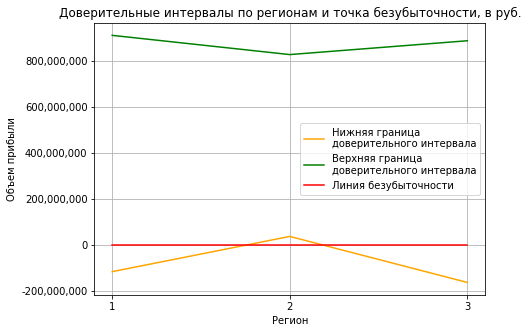

In [18]:
# Отобразим на графике доверительные интервалы по регионам с точкой безубыточности
ax = intervals.plot(
    kind='line',
    x='region',
    y=["lower", "upper", 'breakeven_point'],
    grid=True,
    style={'lower': 'orange', 'upper': 'g', 'breakeven_point': 'r'},
    figsize=(7, 5),
    title='Доверительные интервалы по регионам и точка безубыточности, в руб.'
)

plt.ylabel("Объем прибыли")
plt.xlabel("Регион")
plt.xticks(range(1, 4))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(['Нижняя граница\nдоверительного интервала', 'Верхняя граница\nдоверительного интервала', 'Линия безубыточности'])
plt.show()

<a name='conclusion'></a>
## 5. Общий вывод
[Вернуться во Введение](#introduction)

Взяты базы данных по трем регионам по характеристикам скважин: признаки (f1, f2, f3) и целевым признаком - объемом запасов (product). Для эффективного обучения модели линейной регрессии удалем столбец 'id', поскольку почти 100% всех объектов уникальны. Далее для каждого из регионов были созданы отдельные тестовые и валидационные выборки, на основе которых и осуществлялось обучение моделей линейной регрессии. 

Для демонстрации целесообразности использования техники бутстреп были взяты сначала случайные 500 скважин по каждому из регионов, из которых были взяты 200 лучших по объема запасов нефти. Расчет среднего показателя объема запасов хоть и превосходил точку безубыточности для каждого из регионов, однако, например, для Региона №2 лишь на 3 тыс., ввиду чего риск убытков значительно повышается. Именно далее была рассмотрены показатели с помощью техники бутстреп, рассчитав при этом следующие показатели: 95%-й доверительный интервал (0.025 и 0.975 - квантили), среднее объем прибыли, а также риск убытков.

В конечном итоге получились следующие значения для каждого из регионов:
1. Регион 1:
    - Доверительный интервал (в руб.): -117,742,136 | 911,737,050;
    - Среднее значение прибыли (в руб.): 406,278,783;
    - Риск: 6.7%.
2. Регион 2:
    - Доверительный интервал (в руб.): 35,728,489 | 828,006,639;
    - Среднее значение прибыли (в руб.): 441,504,277;
    - Риск: 1.6%.
3. Регион 3:
    - Доверительный интервал (в руб.): -164,785,166 | 888,206,234;
    - Среднее значение прибыли (в руб.): 385,213,195;
    - Риск: 7.8%.

Проанализировав значения необходимых показателей, можно сделать вывод о том, что наиболее привлекательным регионом для разработки скважин нефти будет **Регион №2**, поскольку даже 0.025-квантиль имеет положительное значение, а также риск убытков удовлетворяет необходимому требования - менее 2.5% - и составляет 1,6%.

**Рекомендация:**
В соответствии с вышеизложенными выводами логично начать разработку скважин в **Регионе №2**, учитывая и низкий риск убытков (1,6%: что ниже необходимого максимума в 2,5%) и возможность получения прибыли довольно большого объема прибыли (~ 400 млн руб. в среднем).